
<br>
Title: Timeseries anomaly detection using an Autoencoder<br>
Author: [pavithrasv](https://github.com/pavithrasv)<br>
Date created: 2020/05/31<br>
Last modified: 2020/05/31<br>
Description: Detect anomalies in a timeseries using an Autoencoder.<br>



<br>
## Introduction<br>
This script demonstrates how you can use a reconstruction convolutional<br>
autoencoder model to detect anomalies in timeseries data.<br>



<br>
## Setup<br>


In [28]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt


<br>
## Load the data<br>
We will use the [Numenta Anomaly Benchmark(NAB)](<br>
https://www.kaggle.com/boltzmannbrain/nab) dataset. It provides artifical<br>
timeseries data containing labeled anomalous periods of behavior. Data are<br>
ordered, timestamped, single-valued metrics.<br>
We will use the `art_daily_small_noise.csv` file for training and the<br>
`art_daily_jumpsup.csv` file for testing. The simplicity of this dataset<br>
allows us to demonstrate anomaly detection effectively.<br>


In [29]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

In [30]:
df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
#df_small_noise = pd.read_csv(df_small_noise_url, parse_dates=True, index_col="timestamp")
df_small_noise = pd.read_csv(df_small_noise_url, parse_dates=True, index_col=0)

In [31]:
df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
#df_daily_jumpsup = pd.read_csv(df_daily_jumpsup_url, parse_dates=True, index_col="timestamp")
df_daily_jumpsup = pd.read_csv(df_daily_jumpsup_url, parse_dates=True, index_col=0)


<br>
## Quick look at the data<br>


In [32]:
print(df_small_noise.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120


In [33]:
print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739



<br>
## Visualize the data<br>
### Timeseries data without anomalies<br>
We will use the following data for training.<br>


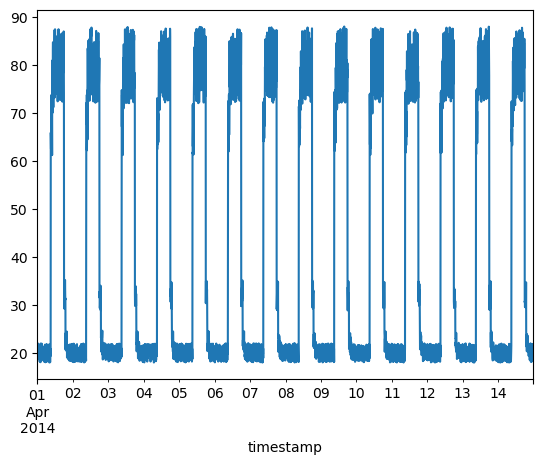

In [34]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()


<br>
### Timeseries data with anomalies<br>
We will use the following data for testing and see if the sudden jump up in the<br>
data is detected as an anomaly.<br>


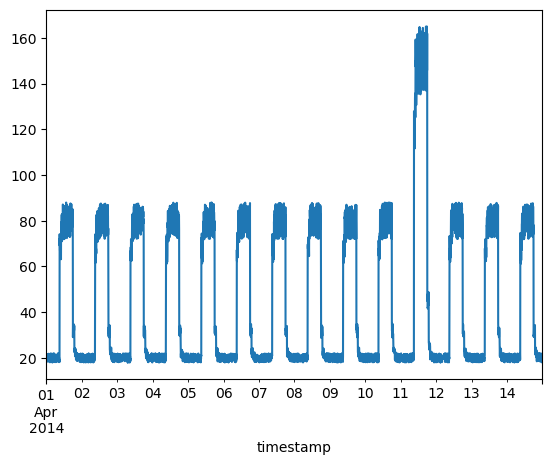

In [35]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()


<br>
## Prepare training data<br>
Get data values from the training timeseries data file and normalize the<br>
`value` data. We have a `value` for every 5 mins for 14 days.<br>
-   24 * 60 / 5 = **288 timesteps per day**<br>
-   288 * 14 = **4032 data points** in total<br>


Normalize and save the mean and std we get,<br>
for normalizing test data.

In [36]:
#training_mean = df_small_noise.mean()
#training_std = df_small_noise.std()
#df_training_value = (df_small_noise - training_mean) / training_std
#print("Number of training samples:", len(df_training_value))

training_mean = df_small_noise.mean()
print(training_mean)
print(df_small_noise)
training_std = df_small_noise.std()
print(training_std)
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))
print(df_training_value)

value    42.438353
dtype: float64
                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
...                        ...
2014-04-14 23:35:00  20.211195
2014-04-14 23:40:00  20.531041
2014-04-14 23:45:00  19.032127
2014-04-14 23:50:00  21.798801
2014-04-14 23:55:00  18.682620

[4032 rows x 1 columns]
value    28.077122
dtype: float64
Number of training samples: 4032
                        value
timestamp                    
2014-04-01 00:00:00 -0.858829
2014-04-01 00:05:00 -0.728993
2014-04-01 00:10:00 -0.848148
2014-04-01 00:15:00 -0.729586
2014-04-01 00:20:00 -0.731173
...                       ...
2014-04-14 23:35:00 -0.791647
2014-04-14 23:40:00 -0.780255
2014-04-14 23:45:00 -0.833640
2014-04-14 23:50:00 -0.735102
2014-04-14 23:55:00 -0.846089

[4032 rows x 1 columns]



<br>
### Create sequences<br>
Create sequences combining `TIME_STEPS` contiguous data values from the<br>
training data.<br>


In [37]:
TIME_STEPS = 288

Generated training sequences for use in the model.

In [38]:
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [39]:
x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)



<br>
## Build a model<br>
We will build a convolutional reconstruction autoencoder model. The model will<br>
take input of shape `(batch_size, sequence_length, num_features)` and return<br>
output of the same shape. In this case, `sequence_length` is 288 and<br>
`num_features` is 1.<br>


In [40]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 144, 32)           256       
                                                                 
 dropout_2 (Dropout)         (None, 144, 32)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 144, 16)          1808      
 ranspose)                                                       
                                                                 
 dropout_3 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                            


<br>
## Train the model<br>
Please note that we are using `x_train` as both the input and the target<br>
since this is a reconstruction model.<br>


In [41]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 2s 49ms/step - loss: 0.4776 - val_loss: 0.0758
Epoch 2/50
27/27 [==============================] - 1s 44ms/step - loss: 0.0825 - val_loss: 0.0442
Epoch 3/50
27/27 [==============================] - 1s 42ms/step - loss: 0.0589 - val_loss: 0.0353
Epoch 4/50
27/27 [==============================] - 1s 40ms/step - loss: 0.0472 - val_loss: 0.0264
Epoch 5/50
27/27 [==============================] - 1s 40ms/step - loss: 0.0393 - val_loss: 0.0229
Epoch 6/50
27/27 [==============================] - 1s 41ms/step - loss: 0.0350 - val_loss: 0.0205
Epoch 7/50
27/27 [==============================] - 1s 42ms/step - loss: 0.0318 - val_loss: 0.0187
Epoch 8/50
27/27 [==============================] - 1s 39ms/step - loss: 0.0293 - val_loss: 0.0174
Epoch 9/50
27/27 [==============================] - 1s 38ms/step - loss: 0.0270 - val_loss: 0.0161
Epoch 10/50
27/27 [==============================] - 1s 38ms/step - loss: 0.0252 - val_loss: 0.0152
Epoch 11/


<br>
Let's plot training and validation loss to see how the training went.<br>


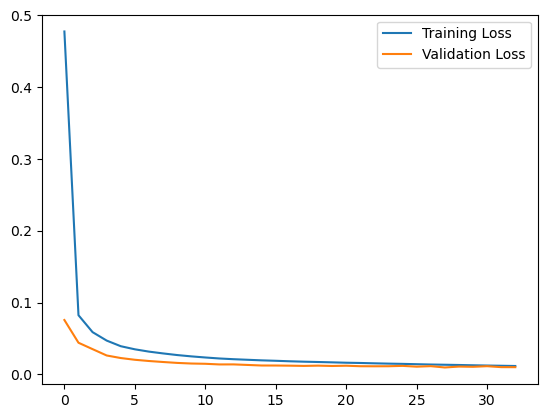

In [42]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()


<br>
## Detecting anomalies<br>
We will detect anomalies by determining how well our model can reconstruct<br>
the input data.<br>
1.   Find MAE loss on training samples.<br>
2.   Find max MAE loss value. This is the worst our model has performed trying<br>
to reconstruct a sample. We will make this the `threshold` for anomaly<br>
detection.<br>
3.   If the reconstruction loss for a sample is greater than this `threshold`<br>
value then we can infer that the model is seeing a pattern that it isn't<br>
familiar with. We will label this sample as an `anomaly`.<br>


Get train MAE loss.

In [43]:
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

118/118 [==============================] - 1s 7ms/step


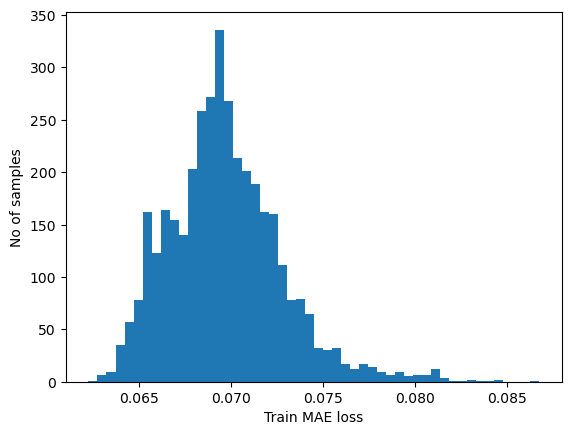

In [44]:
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

Get reconstruction loss threshold.

In [45]:
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

Reconstruction error threshold:  0.08674495884917971



<br>
### Compare recontruction<br>
Just for fun, let's see how our model has recontructed the first sample.<br>
This is the 288 timesteps from day 1 of our training dataset.<br>


Checking how the first sequence is learnt

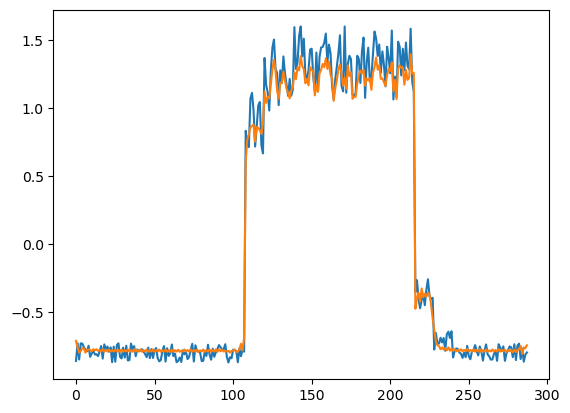

In [46]:
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()


<br>
### Prepare test data<br>


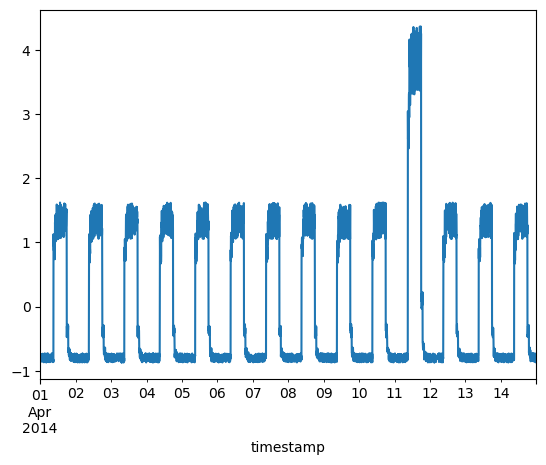

In [47]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

Create sequences from test values.

In [48]:
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

Test input shape:  (3745, 288, 1)


Get test MAE loss.

In [49]:
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

118/118 [==============================] - 1s 8ms/step


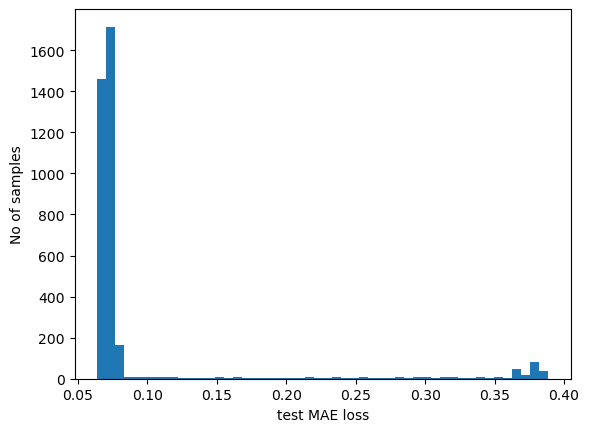

In [50]:
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

Detect all the samples which are anomalies.

In [51]:
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  398
Indices of anomaly samples:  (array([1658, 2521, 2697, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708,
       2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719,
       2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730,
       2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741,
       2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752,
       2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763,
       2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774,
       2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785,
       2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796,
       2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807,
       2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818,
       2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829,
       2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2


<br>
## Plot anomalies<br>
We now know the samples of the data which are anomalies. With this, we will<br>
find the corresponding `timestamps` from the original test data. We will be<br>
using the following method to do that:<br>
Let's say time_steps = 3 and we have 10 training values. Our `x_train` will<br>
look like this:<br>
- 0, 1, 2<br>
- 1, 2, 3<br>
- 2, 3, 4<br>
- 3, 4, 5<br>
- 4, 5, 6<br>
- 5, 6, 7<br>
- 6, 7, 8<br>
- 7, 8, 9<br>
All except the initial and the final time_steps-1 data values, will appear in<br>
`time_steps` number of samples. So, if we know that the samples<br>
[(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point<br>
5 is an anomaly.<br>


data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies

In [52]:
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)


<br>
Let's overlay the anomalies on the original test data plot.<br>


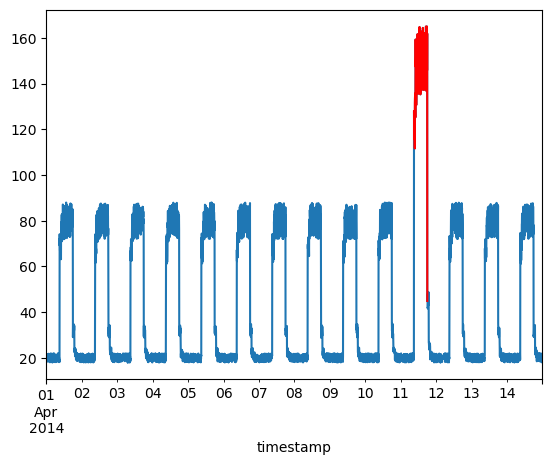

In [53]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()